<a href="https://colab.research.google.com/github/r-diazp/deepL/blob/master/ANN_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![pytorch icon.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWyV5brHNCcNRsfWARFMR78N0Wg5V2hksMVYQeOpYnBn4zKOX2PPWky9wqxVoXuvnUi_s&usqp=CAU)


#Libreries

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


<a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calcula la distancia entre dos cordenadas de GPS<br>

Ecuacion de la distancia:

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

In [2]:
class Utils():
  def __init__(self, data_frame):
    self.data_frame = data_frame    

  #Metodo para calcular Haversine formula
  def haversine_distance(self, lat_1, long_1, lat_2, long_2):
    radius  = 6371  #promedio del radio de la tierra (https://es.wikipedia.org/wiki/Tierra)       
    phi_1, phi_2 = np.radians(self.data_frame[lat_1]), np.radians(self.data_frame[lat_2])
    delta_phi = np.radians(self.data_frame[lat_2] - self.data_frame[lat_1])
    delta_lambda = np.radians(self.data_frame[long_2] - self.data_frame[long_1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = (radius * c) #Distancia en kilometros
    return distance



In [3]:
#Revisar si la GPU esta habilitda y modelo 
print(f'- GPU available: {torch.cuda.is_available()} \
      \n- GPU: {torch.cuda.get_device_name(0)}')

- GPU available: True       
- GPU: Tesla T4


#Carga y preparacion de Tensores

In [4]:
#Cargar DataSet
path = '/content/drive/MyDrive/Dataset/' #Cambiar path del dataset
df = pd.read_csv(path + 'ds-ann-regression.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
#Agregar columna distance al DataFrame
utils = Utils(df) #Instancia objeto utils de la clase Utils 
parameters = ['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']
df['distance'] = utils.haversine_distance(*parameters) #Se llama al metodo haversine_distance del objetvo utils
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [6]:
#TARGET RECURRENTE 
#Ajustar fecha hora a la actual y separarlo por hora, y semana 
df['date_time'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=0) #Ajustar la hora 
df['hour'] = df['date_time'].dt.hour
df['am_pm'] = np.where(df['hour']<12,'am','pm')
df['weekday'] = df['date_time'].dt.strftime("%a")
#df['Weekday2'] = df['date_time'].dt.dayofweek #Colocarlo con formato numerico

#Feactures
#Separar las variables categoricas y continuas 
categorical_cols = ['fare_class', 'hour', 'am_pm', 'weekday']
continuous_cols = ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 
                   'passenger_count', 'distance']
#Target
target = ['fare_amount']  #Esta columna contiene la variable a predecir 

In [7]:
#CATEGORIZAR 
for categorical in categorical_cols:
    df[categorical] = df[categorical].astype('category')
df.dtypes

#Matriz con las categorias 
hour = df['hour'].cat.codes.values
am_pm = df['am_pm'].cat.codes.values
weekday = df['weekday'].cat.codes.values
fare_class = df['fare_class'].cat.codes.values
cat_feacture = [fare_class, hour, am_pm, weekday]

#Convertir las variables cateogricas en tensores en la GPU
#categories_tensor = np.stack([hour, am_pm, weekday], axis=1) # stack unimos las matrices
categories_tensor = np.stack(cat_feacture, axis=1) # stack unimos las matrices
categories_tensor = torch.tensor(categories_tensor, dtype=torch.int64).cuda() #Convert categorical variables to a tensor
categories_tensor[:]

#Convertir las variables continuas en tensores en la GPU
continuous_tensor = np.stack([df[col].values for col in continuous_cols], axis=1) # stack unimos las matrices
continuous_tensor = torch.tensor(continuous_tensor, dtype=torch.float).cuda()

#Convertir la variable a predecir en tensor en la GPU
target_tensor = torch.tensor(df[target].values, dtype=torch.float).reshape(-1,1).cuda() #.reshape(-1,1) es opcional depende de la version de pytorch

#Imprimir resultados
print(f"CATEGORIAS: \
      \n- hour categories: {df['hour'].cat.categories} \
      \n- am_pm categories: {df['am_pm'].cat.categories} \
      \n- weekday categories: {df['weekday'].cat.categories}" )

print(f"\nTENSORS: \n- categories_tensor: {categories_tensor[:]} | cpu/gpu = {categories_tensor.device} \
      \n- continuous_tensor: {continuous_tensor[:]} | cpu/gpu = {continuous_tensor.device} \
      \n- target_tensor: {target_tensor[:]} | cpu/gpu = {target_tensor.device}") 


CATEGORIAS:       
- hour categories: Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')       
- am_pm categories: Index(['am', 'pm'], dtype='object')       
- weekday categories: Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

TENSORS: 
- categories_tensor: tensor([[ 0,  8,  0,  1],
        [ 0, 15,  1,  2],
        [ 1, 11,  0,  2],
        ...,
        [ 1, 18,  1,  3],
        [ 0,  8,  0,  5],
        [ 0, 16,  1,  2]], device='cuda:0') | cpu/gpu = cuda:0       
- continuous_tensor: tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  4

In [8]:
#SPLIT DE LOS TENSORES 
batch_size = 60000
test_size = int(batch_size * .2 )

#Tensores de entranamiento 
categories_train = categories_tensor[:batch_size - test_size]
continuous_train = continuous_tensor[:batch_size - test_size]
target_train = target_tensor[:batch_size - test_size]

#Tensores de prueba 
categories_test = categories_tensor[batch_size - test_size:batch_size]
continuous_test = continuous_tensor[batch_size - test_size:batch_size]
target_test = target_tensor[batch_size - test_size:batch_size]

In [9]:
#Embebido de las variables categoricas (modelo multidimensional de entrada a la ANN)
categorical_size = [len(df[col].cat.categories) for col in categorical_cols] #Total de categorias por columna en cat_cols
embedding_size = [(size, min(50, (size+1)//2) ) for size in categorical_size]
print(f'- categorical_size: {categorical_size} \
      \n- embedding_size: {embedding_size} ')

- categorical_size: [2, 24, 2, 7]       
- embedding_size: [(2, 1), (24, 12), (2, 1), (7, 4)] 


# ANN Model

In [29]:
#Arquitectura de la Red Neuronal 
class Model(nn.Module):
  def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5): #constructor 
    super().__init__() #inicializa con los parametros de nn.Module
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(p) #Porcentaje de neuronas desabilitadas para evitar Overfitting
    self.bn_cont = nn.BatchNorm1d(n_cont) #https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html 
    
    layerlist = []
    n_emb = sum((nf for ni,nf in emb_szs)) #n_emb = 12+1+4=17 || emb_szs = [(24, 12), (2, 1), (7, 4)]
    n_in = n_emb + n_cont #n_cont = Columnas continuas: 6  || n_in = Numero columnas de entrada = 17+6
    
    #Arquitectura de la red neuronal
    for layer in layers:  
        layerlist.append(nn.Linear(n_in, layer))  #n_in=23 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(layer))
        layerlist.append(nn.Dropout(p))
        n_in = layer #n_in toma el valor del ultimo valor de la lista para conectar la capa oculta posterior 
    layerlist.append(nn.Linear(layers[-1], out_sz)) #Ultima capa oculta conectada a la Capa de salida             
    self.layers = nn.Sequential(*layerlist) # * = argumentos || https://realpython.com/python-kwargs-and-args/ 
      

  #funcion para la propagacion atras (Back propagation )
  def forward(self, x_cat, x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):  #propagacion para las variables categoricas 
        embeddings.append(e(x_cat[:,i]))
    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    
    x_cont = self.bn_cont(x_cont) #propagacion para las variables continuas 
    x = torch.cat([x, x_cont], 1)
    x = self.layers(x)
    return x


  #Funcion (metodo) para entrenar la red neuronal artificial 
  def train_model(self, x_cat, x_cont, y_train, criterion, optimizer, epochs=100, figsize=(10,5) ):
    self.criterion = criterion
    start_time = time.time()
    epochs = epochs
    losses = [] #resultados de la funcion de perdida 

    for epoch in range(epochs):
        epoch+=1
        y_pred = self.forward(x_cat, x_cont)  #Se llama al metodo forward que habilita el Back Propagation
        loss = torch.sqrt(criterion(y_pred, y_train) ) #Se calcula la funcion de perdida por cada epoca de entrenamiento
        losses.append(loss) #Se almacenan los resultados de la funcion de perdida en el array losses
        
        if epoch%25 == 1:  #Mostrar avanaces cada 25 epocas 
            print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')

        optimizer.zero_grad() #Algoritmo para el entrenamiento (stochastic gradient descent) https://en.wikipedia.org/wiki/Stochastic_gradient_descent
        loss.backward() #Se propaga la funcion de perdida para ejuste de los pesos de la red neuronal 
        optimizer.step()
    
    #Grafica de convergencia del entrenamiento
    print(f'\nepoch: {epoch:3}  loss: {loss.item():10.8f}') 
    print(f'Duration: {time.time() - start_time:.0f} seconds')
    plt.figure(figsize=figsize) 
    plt.plot(range(epochs), losses)
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epocas');
    plt.grid(True)
    
    return losses, y_pred


      #Validar modelo con datos Test
  def test_validate(self, x_cat, x_cont, y_test, row_valid=0):
    with torch.no_grad():
      y_pred = self.forward(x_cat, x_cont)
      loss = torch.sqrt(self.criterion(y_pred, y_test) )
    print(f'Loss: {loss:.8f}')
      
    if (row_valid) > 0:  
      print(f'{"REAL":>12} {"PREDICTED":>8} {"DIFF":>8}')
      for i in range(row_valid):
        diff = np.abs(y_pred[i].item() - y_test[i].item())
        print(f'{i+1:2}. {y_pred[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')
        

In [ ]:
#Instanciar modelo
torch.manual_seed(20) #Opcional .. creamos una semilla para el proceso de entrenamiento de la red neuronal 
gpu_model = Model(embedding_size, continuous_tensor.shape[1], 1, [500,400,300], p=0.35).cuda() 
#[500,400,200] 3 capas ocultas con 500,400 y 200 neuronas respectivamente, se puede agregar o quitar mar extender el tamaño de la ANN 


#Definimos la funcion de perdida y el optimizador (stochastic gradient descent)
criterion = nn.MSELoss()  #Funcion de perdida 
optimizer = torch.optim.Adam(gpu_model.parameters(), lr=0.01) #Stochastic gradient descent (https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
print(f'- Model Arquitecture: {gpu_model} \n- Model is GPU(cuda): {next(gpu_model.parameters()).is_cuda}') #imprime arquitectura 


epoch:   1 loss: 12.56695366
epoch:  26 loss: 3.93844080
epoch:  51 loss: 3.27136922
epoch:  76 loss: 2.98878050
epoch: 101 loss: 2.84055638
epoch: 126 loss: 2.74246883
epoch: 151 loss: 2.65365529
epoch: 176 loss: 2.65258074
epoch: 201 loss: 2.64821792
epoch: 226 loss: 2.58463025
epoch: 251 loss: 2.53538561
epoch: 276 loss: 2.51708150

epoch: 300  loss: 2.51005244
Duration: 15 seconds


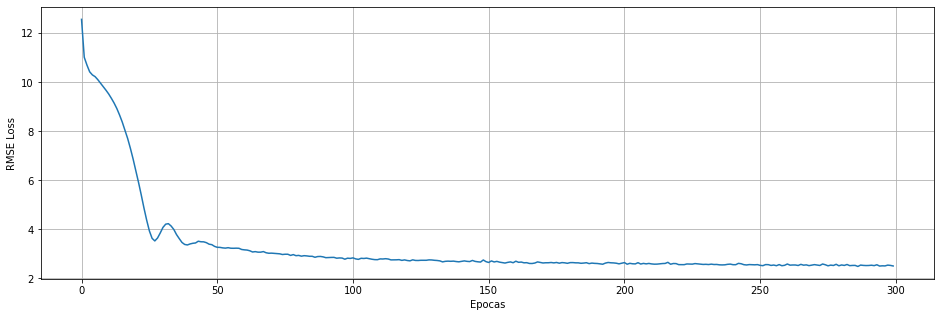

In [32]:
#Entrenar modelo 
epochs = 300
model_parameters = [categories_train, continuous_train, target_train, criterion, optimizer, epochs, (16,5)] #parametros para el entrenamiento
loss, y_pred =gpu_model.train_model(*model_parameters) #Inicia proceso de entramiento (* se usa para locar los datos del array como parametros)

#Validar modelo

In [34]:
gpu_model.test_validate(categories_test, continuous_test, target_test, 50)

Loss: 2.68156505
        REAL PREDICTED     DIFF
 1.   4.1870   2.9000   1.2870
 2.   4.0533   5.7000   1.6467
 3.   6.1522   7.7000   1.5478
 4.  12.9938  12.5000   0.4938
 5.   3.6324   4.1000   0.4676
 6.   4.9850   5.3000   0.3150
 7.   4.3506   3.7000   0.6506
 8.  16.3199  14.5000   1.8199
 9.   5.1590   5.7000   0.5410
10.  11.5303  10.1000   1.4303
11.   4.5848   4.5000   0.0848
12.   6.6411   6.1000   0.5411
13.   6.0972   6.9000   0.8028
14.  11.0721  14.1000   3.0279
15.   5.6013   4.5000   1.1013
16.  34.8307  34.1000   0.7307
17.  45.5832  12.5000  33.0832
18.   4.6402   4.1000   0.5402
19.   8.1997   8.5000   0.3003
20.   6.5807   5.3000   1.2807
21.  14.1623  11.3000   2.8623
22.  11.9165  10.5000   1.4165
23.  14.9887  15.3000   0.3113
24.  15.7802  14.9000   0.8802
25.  48.7996  49.5700   0.7704
26.   6.2227   5.3000   0.9227
27.   5.5552   3.7000   1.8552
28.   7.3132   6.5000   0.8132
29.  14.7792  14.1000   0.6792
30.   6.3500   4.9000   1.4500
31.   4.4498   3.7000